In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


## Problem 1

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [4]:
data_root = '.'
image_size = 28

def image_samples(dir_name):
    target_dir = os.path.join(data_root, dir_name)
    
    letters = os.listdir(target_dir)  
    
    for letter in letters:
        letter_dir_path = target_dir + "/" + letter
        
        try:
            image_paths = os.listdir(letter_dir_path)

        except:
            print ("{} is not a directory...\n".format(letter_dir_path))
            continue
        
        np.random.seed()
        index = np.random.randint(len(image_paths))
        
        filename = image_paths[index]
        image_path = target_dir + "/" + letter + "/" + filename
        image = Image(filename = image_path, width = image_size, height = image_size)
        
        print ("Letter: {} - Path: {}".format(letter, image_path))
        display(image)

image_samples('notMNIST_large')

Letter: A - Path: ./notMNIST_large/A/SmFudXMtUmlnaHQub3Rm.png


./notMNIST_large/A.pickle is not a directory...

Letter: B - Path: ./notMNIST_large/B/RXhjZWxzaW9yLUl0YWxpYy5vdGY=.png


./notMNIST_large/B.pickle is not a directory...

Letter: C - Path: ./notMNIST_large/C/RmF0c2Fuc0NvbnR1ci50dGY=.png


./notMNIST_large/C.pickle is not a directory...

Letter: D - Path: ./notMNIST_large/D/TmV1dmFyZXNlLUJvbGRJdGFsaWMudHRm.png


./notMNIST_large/D.pickle is not a directory...

Letter: E - Path: ./notMNIST_large/E/UnVhY2ggTEVUIFBsYWluMS4wLnR0Zg==.png


./notMNIST_large/E.pickle is not a directory...

Letter: F - Path: ./notMNIST_large/F/Q29taWMgR2VlayBJdGFsaWMudHRm.png


./notMNIST_large/F.pickle is not a directory...

Letter: G - Path: ./notMNIST_large/G/UmVhbGl0eS1IZWF2eS5vdGY=.png


./notMNIST_large/G.pickle is not a directory...

Letter: H - Path: ./notMNIST_large/H/VHJhZGUgR290aGljIExUIENvbmRlbnNlZCBOby4gMTgudHRm.png


./notMNIST_large/H.pickle is not a directory...

Letter: I - Path: ./notMNIST_large/I/SVRDIFF1b3J1bSBMaWdodC5wZmI=.png


./notMNIST_large/I.pickle is not a directory...

Letter: J - Path: ./notMNIST_large/J/TWFldGwgRXh0cmFCb2xkT2JsaXF1ZS50dGY=.png


./notMNIST_large/J.pickle is not a directory...



In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

## Problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

Label: 0


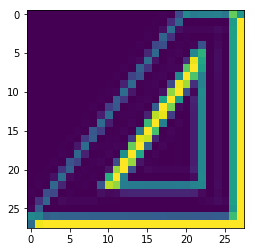



Label: 1


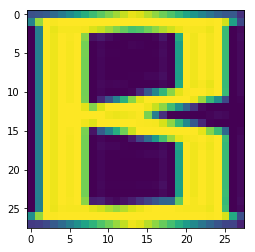



Label: 2


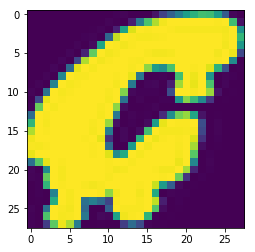



Label: 3


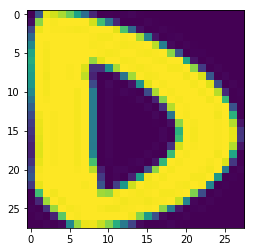



Label: 4


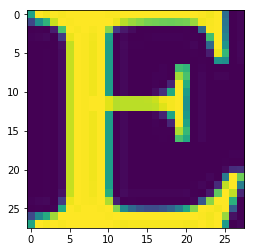



Label: 5


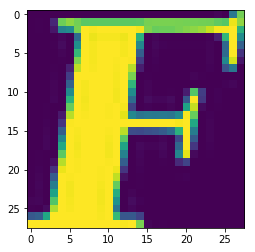



Label: 6


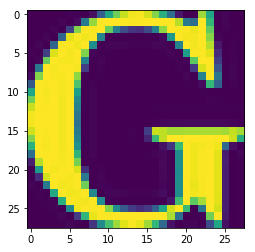



Label: 7


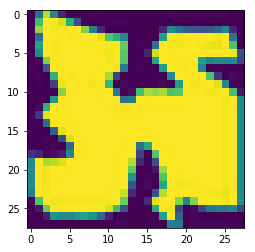



Label: 8


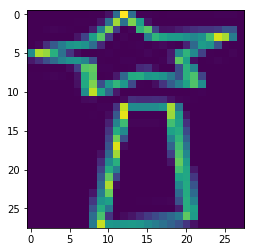



Label: 9


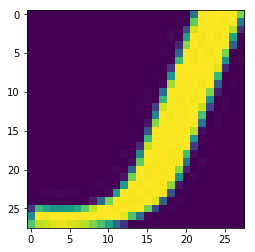

In [6]:
import matplotlib.image as mpImg

def feature_label_sampler(dir_name):    
    for label, data_path in enumerate(train_datasets):
        dataset = pickle.load(open(data_path, "rb"))
        
        np.random.seed()
        index = np.random.randint(len(dataset))
        
        data = dataset[index]
        
        print ("Label: {}".format(label))
        image_plot = plt.imshow(data)
        plt.show(image_plot)
        print ('\n')

feature_label_sampler('notMNIST_large')

## Problem 3
Another check: we expect the data to be balanced across classes. Verify that.

In [7]:
def balance_checker():
    for label, data_path in enumerate(train_datasets):
        dataset = pickle.load(open(data_path, "rb"))
        print ("Label: {} has {} images".format(label, len(dataset)))

balance_checker()

Label: 0 has 52909 images
Label: 1 has 52911 images
Label: 2 has 52912 images
Label: 3 has 52911 images
Label: 4 has 52912 images
Label: 5 has 52912 images
Label: 6 has 52912 images
Label: 7 has 52912 images
Label: 8 has 52912 images
Label: 9 has 52911 images


In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4
Convince yourself that the data is still good after shuffling!

[20000 20000 20000 20000 20000 20000 20000 20000 20000 20000]
Label: 7


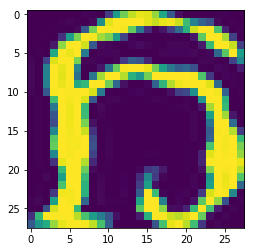



Label: 2


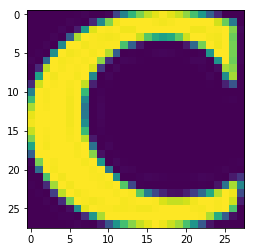



Label: 0


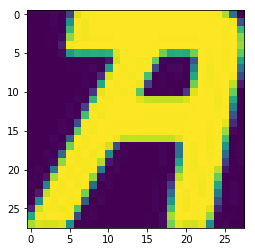



Label: 1


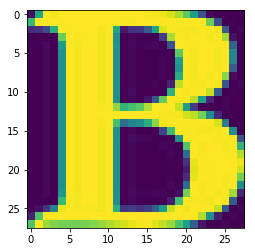



Label: 9


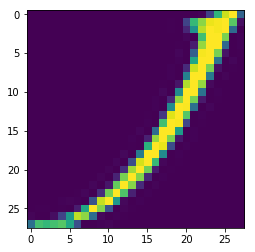



Label: 6


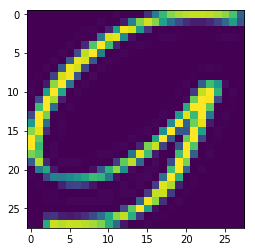



Label: 3


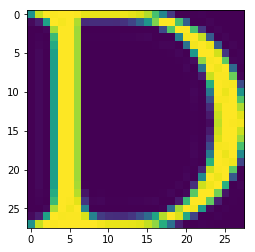



Label: 8


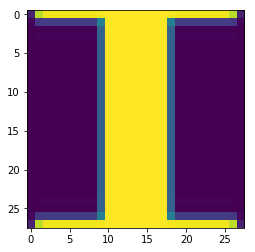



Label: 5


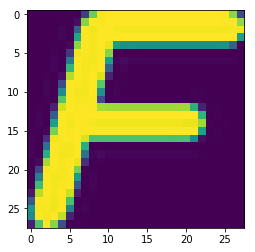



Label: 4


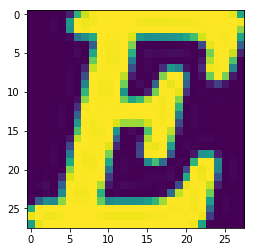

In [10]:
def shuffled_tester():
    label_bins = np.bincount(train_labels)
    print (label_bins)
    
    index = 0
    picked_labels = []
    
    np.random.seed()
    start = np.random.randint(len(train_labels))
    
    while index < len(label_bins):
        if start >= len(train_labels):
            start = 0 + (start - len(train_labels))
        else:
            label = train_labels[start]
            if label not in picked_labels:
                data = train_dataset[start]
                print ("Label: {}".format(label))
                image_plot = plt.imshow(data)
                plt.show(image_plot)
                print ('\n')
                picked_labels.append(label)
                start += 1
                index += 1
            else:
                start += 1

shuffled_tester()

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [ ]:
def sme(array_1, array_2):
    error = np.sum((array_1 - array_2) ** 2)
    
    try:
        error /= (array_1.shape[0] * array_2.shape[1])
        
    except:
        error /= array_1.shape[0]
    
    return error

def overlap_counter(labels_1, dataset_1, labels_2, dataset_2):
    lab1_length = len(labels_1)
    lab2_length = len(labels_2)
    ds1_length = len(dataset_1)
    ds2_length = len(dataset_2)
    
    lab1_half = lab1_length//2
    lab2_half = lab2_length//2
    ds1_half = ds1_length//2
    ds2_half = ds2_length//2
    
    labels_11 = labels_1[:lab1_half]
    labels_12 = labels_1[lab1_half:]
    labels_21 = labels_2[:lab2_half]
    labels_22 = labels_2[lab2_half:]
    
    dataset_11 = dataset_1[:ds1_half]
    dataset_12 = dataset_1[ds1_half:]
    dataset_21 = dataset_2[:ds2_half]
    dataset_22 = dataset_2[ds2_half:]
    
    if (ds1_length == 1 & ds2_length == 1):
        if (labels_1[0] == labels_2[0]):
            ds1_sample = dataset_1[0][14]
            ds2_sample = dataset_2[0][14]

            sample_error = sme(ds1_sample, ds2_sample)

            if (sample_error == 0):
                error = sme(dataset_1[0], dataset_2[0])

                if (error == 0):
                    return 1
        return 0
    
    elif (ds1_half == 0):
        return (overlap_counter(labels_12, dataset_12, labels_21, dataset_21) +
                overlap_counter(labels_12, dataset_12, labels_22, dataset_22))
    
    elif (ds2_half == 0):
        return (overlap_counter(labels_11, dataset_11, labels_22, dataset_22) +
                overlap_counter(labels_12, dataset_12, labels_22, dataset_22))
    
    else:
        return (overlap_counter(labels_11, dataset_11, labels_21, dataset_21) +
                overlap_counter(labels_11, dataset_11, labels_22, dataset_22) +
                overlap_counter(labels_12, dataset_12, labels_21, dataset_21) +
                overlap_counter(labels_12, dataset_12, labels_22, dataset_22))

def overlap_checker():
    train_test_count = overlap_counter(train_labels,
                                       train_dataset,
                                       test_labels,
                                       test_dataset)
    train_test_overlap = (train_test_count/(len(train_dataset) * len(test_dataset))) * 100
    print ("Train-Test overlap: {}% \n".format(train_test_overlap))
    
    train_valid_count = overlap_counter(train_labels,
                                        train_dataset,
                                        valid_labels,
                                        valid_dataset)
    train_valid_overlap = (train_valid_count/(len(train_dataset) * len(valid_dataset))) * 100
    print ("Train-Valid overlap: {}% \n".format(train_valid_overlap))

    valid_test_count = overlap_counter(valid_labels,
                                       valid_dataset,
                                       test_labels,
                                       test_dataset)
    valid_test_overlap = (valid_test_count/(len(valid_dataset) * len(test_dataset))) * 100

    print ("Test-Valid overlap: {}%".format(valid_test_overlap))

overlap_checker()

## Problem 6

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [14]:
def ots_classifier():
    pass

ots_classifier()